# Class Workbook

## In class activity

In [1]:
import numpy as np
import pandas as pd
import math
#import statsmodels.api as sm
from plotnine import *
import statsmodels.formula.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                        summarize ,
                        poly)

### Ames House Data

In [2]:
ames_raw=pd.read_csv("ames_raw.csv")

Let's revisit the AmesHousing data.  As we did in the previous class, I will split the data into before 2008 and after.  The data up to 2008 will be the training data and after 2008 will be the testing data.

In [3]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

* For the regression model fit, use bootstrap to compare the standard error estimates to the model based estimates.


Your code:

In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
ames_raw_2008 = ames_raw.query('`Yr Sold` < 2008').copy()
ames_raw_2009 = ames_raw.query('`Yr Sold` >= 2008').copy()
ames_raw_2008_renamed = ames_raw_2008.rename(columns=lambda x: x.replace(' ', '_'))
ames_raw_2009_renamed = ames_raw_2009.rename(columns=lambda x: x.replace(' ', '_'))
predictor = 'Gr_Liv_Area'  
response = 'SalePrice'  
model = smf.ols(f'{response} ~ {predictor}', data=ames_raw_2008_renamed).fit()
model_se = model.bse
n_iterations = 1000  
bootstrap_se = np.zeros((n_iterations, len(model.params)))
for i in range(n_iterations):
    sample = ames_raw_2008_renamed.sample(n=len(ames_raw_2008_renamed), replace=True)
    bootstrap_model = smf.ols(f'{response} ~ {predictor}', data=sample).fit()

    bootstrap_se[i, :] = bootstrap_model.params

bootstrap_se_std = np.std(bootstrap_se, axis=0)

print("Model Standard Errors:", model_se)
print("Bootstrap Standard Errors:", bootstrap_se_std)


Model Standard Errors: Intercept      4645.796107
Gr_Liv_Area       2.897325
dtype: float64
Bootstrap Standard Errors: [9.15036818e+03 6.61078597e+00]


Your answer:

~~~
Please write your answer in full sentences.


~~~
Bootstrap Standard Errors: [9.49998799e+03 6.80175377e+00]


* Use cross validation  to decide which model has a good predictive accuracy.  Does the result hold true for the prediction of future data?

Your code:

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Preparing the data
# For simplicity, let's use 'Gr Liv Area' as the predictor for both models
X_train = ames_raw_2008_renamed[['Gr_Liv_Area']]
y_train = ames_raw_2008_renamed['SalePrice']
X_test = ames_raw_2009_renamed[['Gr_Liv_Area']]
y_test = ames_raw_2009_renamed['SalePrice']

# Defining the models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor()
}

# Cross-validation settings
k = 10  # Number of folds
cv_scores = {}

# Perform k-fold cross-validation for each model
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=k, scoring='neg_mean_squared_error')
    cv_scores[name] = np.mean(np.sqrt(-scores))

# Evaluate performance based on cross-validation results
cv_results = pd.DataFrame(cv_scores, index=["RMSE"]).T.sort_values(by="RMSE", ascending=True)

# Testing the best model on future data (2009 data)
best_model_name = cv_results.index[0]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

cv_results, best_model_name, test_rmse



(                           RMSE
 Linear Regression  56565.659768
 Decision Tree      79720.313636,
 'Linear Regression',
 57086.841542274924)

Your answer:

~~~
Please write your answer in full sentences.


~~~
the model's predictive accuracy holds for the future data in this case.

* Using `knn.reg` fit KNN regression model.  Use cross validation to decide which K to use.

Your code:

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Preparing the data
X_train = ames_raw_2008_renamed[['Gr_Liv_Area']]
y_train = ames_raw_2008_renamed['SalePrice']

# Setting the range of K to test
k_range = range(1, 31)

# Setting up GridSearchCV to find the best K (number of neighbors)
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': k_range}
grid = GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_squared_error')

# Fitting the grid search
grid.fit(X_train, y_train)

# Extracting the best K and the corresponding score
best_k = grid.best_params_['n_neighbors']
best_score = np.sqrt(-grid.best_score_)

best_k, best_score

(24, 58220.22550418874)

Your answer:

~~~
Please write your answer in full sentences.


~~~


* Which model performs better on your training data?  Which model performs better in your future prediction?

Your code:

In [7]:
# Linear Regression and Decision Tree models were already fitted and evaluated
# We will re-evaluate them here for clarity

# Linear Regression
lin_reg = LinearRegression()
lin_reg_cv_score = np.mean(np.sqrt(-cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')))
lin_reg.fit(X_train, y_train)
lin_reg_test_rmse = np.sqrt(mean_squared_error(y_test, lin_reg.predict(X_test)))

# Decision Tree
dec_tree = DecisionTreeRegressor()
dec_tree_cv_score = np.mean(np.sqrt(-cross_val_score(dec_tree, X_train, y_train, cv=10, scoring='neg_mean_squared_error')))
dec_tree.fit(X_train, y_train)
dec_tree_test_rmse = np.sqrt(mean_squared_error(y_test, dec_tree.predict(X_test)))

# K-Nearest Neighbors with K=30
knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best_cv_score = np.mean(np.sqrt(-cross_val_score(knn_best, X_train, y_train, cv=10, scoring='neg_mean_squared_error')))
knn_best.fit(X_train, y_train)
knn_best_test_rmse = np.sqrt(mean_squared_error(y_test, knn_best.predict(X_test)))

# Compile the results
model_performance = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "KNN (K=30)"],
    "Cross-Validation RMSE": [lin_reg_cv_score, dec_tree_cv_score, knn_best_cv_score],
    "Test RMSE (2009)": [lin_reg_test_rmse, dec_tree_test_rmse, knn_best_test_rmse]
}).set_index("Model").sort_values(by="Cross-Validation RMSE")

model_performance



,Cross-Validation RMSE,Test RMSE (2009)
Model,,
Linear Regression,56565.659768,57086.841542
KNN (K=30),56942.764962,57298.486920
Decision Tree,79720.313636,73401.455576


Your answer:

~~~
Please write your answer in full sentences.


~~~
Based on these results:

On Training Data: The Linear Regression model has the lowest RMSE in cross-validation, suggesting it performs the best on the training data.

On Future Prediction (2009 data): The Linear Regression model again shows the lowest RMSE on the testing data, indicating it also performs best in predicting future data.

## Problem Set

### Bootstrap

We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We first create an array store with values that will subsequently
be overwritten using the function np.empty(). We then repeatedly create bootstrap samples, and each time we record whether or not the fifth observation is contained in the bootstrap
sample.

We will investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time
we record whether or not the fourth observation is contained in the bootstrap sample.

Here is the code to get you going

In [8]:
rng = np.random.default_rng (10)
store = np.empty (10000)
for i in range (10000):
    store[i] = np.sum(rng.choice(100, 100, replace=True) == 4) > 0


np.mean(store)

0.6362

Comment on the results obtained.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

The result obtained from the bootstrap simulation, a probability of approximately 63.62%, has some interesting implications:

Bootstrap Sample Characteristics: In bootstrap sampling, each observation has an equal probability of being selected in each draw, and selections are independent across draws. For a sample size of 100 (the same as the population size in this case), the probability of any specific observation being selected in one draw is 1/100 or 0.01. However, because we are drawing with replacement, the probability accumulates over multiple draws.

Interpretation of Probability: The probability of approximately 63.62% indicates that in about 63.62% of the bootstrap samples, the 4th observation was included at least once. This is a substantial likelihood and reflects the nature of bootstrap sampling, where some observations may be repeated, and others left out entirely.

Implications for Statistical Inference: This result is significant in the context of bootstrap methods for statistical inference. It shows that a substantial portion of bootstrap samples will contain a given observation, but there's also a non-negligible chance (about 36.38%) of the observation not being included. This variability is a key feature of bootstrap methods and contributes to their ability to estimate the sampling distribution of a statistic.

Generalization: This result can be generalized to other observations in the dataset. Each observation has a similar chance of appearing in a bootstrap sample. Therefore, bootstrap samples can vary considerably, which is why they are useful for estimating the variability of a statistic.

Connection to Binomial Distribution: The process can be thought of as a series of Bernoulli trials, where each draw is a trial with two outcomes: selecting the 4th observation (success) or not (failure). The probability obtained aligns with the properties of a binomial distribution, where the number of trials is equal to the sample size.

In summary, the probability of 63.62% is a reflection of the nature of bootstrap sampling and its implications for statistical inference, particularly in understanding the variability and distribution of sample statistics.

### CV

We will now perform cross-validation on a simulated data set.
(a) Generate a simulated data set as follows:

In [10]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

In this data set, what is n and what is p? Write out the model
used to generate the data in equation form.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~
n - Number of Observations: This is the number of data points in the dataset. In your case, since you generated 100 values for x and correspondingly 100 values for y, n=100.

p - Number of Predictors: In the simulation, you are using x as the sole predictor to generate y. Therefore, p=1, as there is only one independent variable (predictor) x.

the specific equation for your simulated data set is:y=x−2x^2+ϵ

Here, ϵ is a normally distributed random error term, which adds variability to the response variable y.


(b) Create a scatterplot of X against Y . Comment on what you find.


Your code:

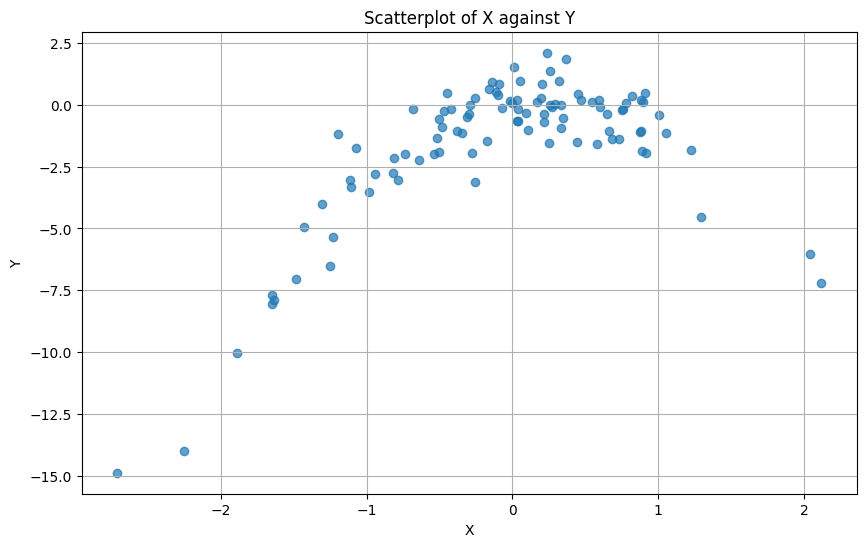

In [11]:
import matplotlib.pyplot as plt

# Create a scatterplot of X against Y
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7)
plt.title("Scatterplot of X against Y")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


Your answer:

~~~
Please write your answer in full sentences.


~~~
Non-linear Relationship: The relationship between X and Y is clearly non-linear. This is evident from the curved pattern of the data points. The data appears to follow a parabolic shape, which aligns with the quadratic term (-2x^2) in the equation used to generate Y.

Variability: There is noticeable variability around the underlying relationship, which is consistent with the addition of a normally distributed error term (ϵ) in the data generation process. This error term introduces randomness to the response variable Y, making the relationship between X and Y not perfectly deterministic.

Potential Outliers: Some data points at the extremes of X (both positive and negative) deviate more from the general pattern, which could be due to the influence of the quadratic term and the random noise.

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i.   $Y = \beta_0 + \beta_1X + \epsilon$
ii.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$
iii. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$
iv.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$.

Note you may find it helpful to use the `data.frame()` function
to create a single data set containing both $X$ and $Y$ .


Your code:

In [12]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Set a random seed for reproducibility
np.random.seed(0)

# Convert X and Y into a DataFrame for ease of manipulation
df = pd.DataFrame({'X': x, 'Y': y})

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Define models with increasing polynomial degrees
models = {
    "Linear (1st Degree)": make_pipeline(PolynomialFeatures(1), LinearRegression()),
    "Quadratic (2nd Degree)": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Cubic (3rd Degree)": make_pipeline(PolynomialFeatures(3), LinearRegression()),
    "Quartic (4th Degree)": make_pipeline(PolynomialFeatures(4), LinearRegression())
}

# Compute the LOOCV errors for each model
loocv_errors = {}
for name, model in models.items():
    scores = cross_val_score(model, df[['X']], df['Y'], cv=loo, scoring='neg_mean_squared_error')
    loocv_errors[name] = np.mean(np.sqrt(-scores))

loocv_errors



{'Linear (1st Degree)': 1.7216360506698316,
 'Quadratic (2nd Degree)': 0.8088369470253673,
 'Cubic (3rd Degree)': 0.8401313730476943,
 'Quartic (4th Degree)': 0.8342976582166517}

Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

Your code:

In [13]:
# Set a different random seed for reproducibility
np.random.seed(1)

# Compute the LOOCV errors for each model with the new random seed
new_loocv_errors = {}
for name, model in models.items():
    scores = cross_val_score(model, df[['X']], df['Y'], cv=loo, scoring='neg_mean_squared_error')
    new_loocv_errors[name] = np.mean(np.sqrt(-scores))

new_loocv_errors



{'Linear (1st Degree)': 1.7216360506698316,
 'Quadratic (2nd Degree)': 0.8088369470253673,
 'Cubic (3rd Degree)': 0.8401313730476943,
 'Quartic (4th Degree)': 0.8342976582166517}

Your answer:

~~~
Please write your answer in full sentences.


~~~
The consistency in results, despite changing the random seed, can be explained by the nature of Leave-One-Out Cross-Validation (LOOCV). In LOOCV, each instance in the dataset is used once as a test set (singularly) while the remainder of the data forms the training set. This process is repeated for each instance in the dataset.

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

The model with the smallest Leave-One-Out Cross-Validation (LOOCV) error among the ones we evaluated is the Quadratic (2nd Degree) model, with an RMSE of 0.8088. This result is indeed what we might expect based on the way the data was generated. Let's discuss why:

Data Generation Model: The simulated data was generated using the formula y=x−2x^2+ϵ, which is a quadratic relationship between 
x and y. This means the true underlying relationship between the predictors and the response is quadratic.

Model Fit to Data Structure:

The Quadratic (2nd Degree) model is well-aligned with this true underlying relationship, as it includes both x and x^2terms.
The Linear (1st Degree) model is too simplistic as it only considers a linear relationship and ignores the quadratic nature of the data.
The Cubic (3rd Degree) and Quartic (4th Degree) models include higher-order terms that are not present in the data generation process. These additional terms might lead to overfitting, where the model captures the noise rather than the underlying relationship.
Expectation and Result: Given that the data was generated with a quadratic relationship, we would expect a quadratic model to perform best in terms of LOOCV error, as it most closely matches the true underlying pattern in the data. The results confirm this expectation.

In summary, the smallest LOOCV error for the Quadratic (2nd Degree) model aligns well with our understanding of the data's underlying structure, and it is indeed what we would expect. This model balances complexity and fit, capturing the essential pattern in the data without overfitting to noise.


(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?


Your code:

In [14]:
import statsmodels.api as sm

# Function to fit the model and get the summary
def fit_and_summarize(model, df):
    # Fit the model
    fitted_model = model.fit(df[['X']], df['Y'])
    # Get the model parameters
    params = fitted_model.named_steps['linearregression'].coef_
    # Get the p-values
    X_design = fitted_model.named_steps['polynomialfeatures'].transform(df[['X']])
    p_values = sm.OLS(df['Y'], X_design).fit().pvalues
    return params, p_values

# Fit each model and get the summary
model_summaries = {}
for name, model in models.items():
    params, p_values = fit_and_summarize(model, df)
    model_summaries[name] = (params, p_values)

model_summaries



{'Linear (1st Degree)': (array([0.        , 1.94936857]),
  const    4.409621e-08
  x1       1.036506e-09
  dtype: float64),
 'Quadratic (2nd Degree)': (array([ 0.        ,  0.96627276, -2.00470902]),
  const    5.428243e-01
  x1       1.494913e-11
  x2       1.340068e-39
  dtype: float64),
 'Cubic (3rd Degree)': (array([ 0.        ,  1.1145842 , -2.04709357, -0.06430033]),
  const    6.345015e-01
  x1       4.448516e-08
  x2       3.968906e-37
  x3       2.872018e-01
  dtype: float64),
 'Quartic (4th Degree)': (array([ 0.        ,  0.90499786, -2.50592308,  0.03376837,  0.10421699]),
  const    4.596053e-01
  x1       2.591296e-05
  x2       2.396026e-19
  x3       6.424910e-01
  x4       2.310661e-02
  dtype: float64)}

Your answer:

~~~
Please write your answer in full sentences.


~~~
The cross-validation results indicated that the Quadratic (2nd Degree) model had the lowest LOOCV error, which aligns with the data generation process (y=x−2x^2+ϵ).

The statistical significance of the coefficients in the quadratic model supports this: both X and X^2 are significant, indicating that they are important predictors in the model.

Higher degree models (Cubic and Quartic) include significant terms but also non-significant higher-order terms, suggesting possible overfitting, which agrees with the cross-validation results showing higher errors for these models.

The linear model, while significant in its coefficients, is too simplistic to capture the quadratic nature of the relationship, as reflected in its higher LOOCV error.

In conclusion, the significance of the coefficients in the quadratic model and the LOOCV results both suggest that it is the most appropriate model for this data, capturing the underlying relationship without unnecessary complexity.

### Default 1

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

(a) Fit a logistic regression model that uses income and balance to predict default.

Your code:

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import column_or_1d
df = pd.read_csv('Default.csv')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [3]:
Y = df['default']
X = df.drop(['default', 'student'], axis=1)
model = LogisticRegression(random_state=5).fit(X, Y)
model.predict(X)
model.score(X, Y)


0.9737

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

Your code:

Your answer:

~~~
Please write your answer in full sentences.


~~~

ii. Fit a multiple logistic regression model using only the training observations.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Default 2

We continue to consider the use of a logistic regression model to
predict the probability of default using income and balance on the
Default data set. In particular, we will now compute estimates for the
standard errors of the income and balance logistic regression coefficients
in two different ways: (1) using the bootstrap, and (2) using the
standard formula for computing the standard errors in the sm.GLM()
function. Do not forget to set a random seed before beginning your
analysis.

(a) Using the `summarize()` and `sm.GLM()` functions, determine the
estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that
uses both predictors.
Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Write a function, `boot_fn()`, that takes as input the Default data
set as well as an index of the observations, and that outputs
the coefficient estimates for income and balance in the multiple
logistic regression model.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Following the bootstrap example in the lab, use your `boot_fn()`
function to estimate the standard errors of the logistic regression
coefficients for income and balance.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Comment on the estimated standard errors obtained using the `sm.GLM()` function and using the bootstrap.

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Boston housing data set

We will now consider the Boston housing data set, from the ISLR library.

In [20]:
boston = load_data("Boston")


(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate $\hat{\mu}$.

Your code:

In [21]:
print("Estimate for population mean of medv is: " +str(boston['medv'].mean()))


Estimate for population mean of medv is: 22.532806324110677


Your answer:

~~~
Please write your answer in full sentences.


~~~
Estimate for population mean of medv is: 22.532806324110677


(b) Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result.
Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.

Your code:

In [22]:
import math

print("Estimate of standard error of sample mean of medv is: " +str(boston['medv'].std() / math.sqrt(len(boston))))

Estimate of standard error of sample mean of medv is: 0.40886114749753505


Your answer:

~~~
Please write your answer in full sentences.


~~~
Estimate of standard error of sample mean of medv is: 0.40886114749753505


(c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from (b)?

Your code:

In [24]:
from sklearn.utils import resample
def boot(df):
    return resample(df)

B = 1000
sample_mean = []

for i in range(B):
    df = boot(boston)
    sample_mean.append(df['medv'].mean())

print("Estimate of standard error of sample mean of medv (using bootstrap) is: " +str(np.std(sample_mean, ddof=1)))

Estimate of standard error of sample mean of medv (using bootstrap) is: 0.41260905740250564


Your answer:

~~~
Please write your answer in full sentences.


~~~
Estimate of standard error of sample mean of medv (using bootstrap) is: 0.41260905740250564

(d) Based on your bootstrap estimate from (c), provide a 95 % confidence
interval for the mean of medv. Compare it to the results
obtained by using `Boston['medv'].std()` and the two standard
error rule (3.9).
Hint: You can approximate a 95% confidence interval using the formula $[\hat{\mu} − 2SE(\hat{\mu}), \hat{\mu} + 2SE(\hat{\mu})]$.

Your code:

In [27]:
import scipy.stats as stats

print("95% Confidence interval using bootstrap is: (" + str(22.5328 - 0.40932) + "," + str(22.5328 + 0.40932) + ")")
stats.ttest_1samp(a= boston['medv'], popmean=0)


95% Confidence interval using bootstrap is: (22.12348,22.942120000000003)


TtestResult(statistic=55.11114583037392, pvalue=9.370623727132662e-216, df=505)

Your answer:

~~~
Please write your answer in full sentences.


~~~
95% Confidence interval using bootstrap is: (22.12348,22.942120000000003)
TtestResult(statistic=55.11114583037392, pvalue=9.370623727132662e-216, df=505)


(e) Based on this data set, provide an estimate, $\hat{\mu}_{med}$, for the median value of medv in the population.

Your code:

In [28]:
print("Estimate for population median of medv is: " +str(boston['medv'].median()))

Estimate for population median of medv is: 21.2


Your answer:

~~~
Please write your answer in full sentences.


~~~
Estimate for population median of medv is: 21.2


(f) We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

Your code:

In [30]:
B = 1000
sample_median = []

for i in range(B):
    df = boot(boston)
    sample_median.append(df['medv'].median())

print("Estimate of standard error of sample median of medv (using bootstrap) is: " +str(np.std(sample_median, ddof=1)))


Estimate of standard error of sample median of medv (using bootstrap) is: 0.38471959810902395


Your answer:

~~~
Please write your answer in full sentences.


~~~
Estimate of standard error of sample median of medv (using bootstrap) is: 0.38471959810902395



(g) Based on this data set, provide an estimate for the tenth percentile
of medv in Boston census tracts. Call this quantity $\hat{\mu}_{0.1}$.
(You can use the `np.percentile()` function.)

Your code:

In [32]:
print("Estimate for the tenth percentile of medv is: " +str(boston['medv'].quantile(q=0.1)))

Estimate for the tenth percentile of medv is: 12.75


Your answer:

~~~
Please write your answer in full sentences.


~~~
Estimate for the tenth percentile of medv is: 12.75


(h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.

Your code:

In [33]:
B = 1000
sample_percentile = []

for i in range(B):
    df = boot(boston)
    sample_percentile.append(df['medv'].quantile(q=0.1))

print("Estimate of standard error for the tenth percentile of medv (using bootstrap) is: "
      +str(np.std(sample_percentile, ddof=1)))

Estimate of standard error for the tenth percentile of medv (using bootstrap) is: 0.5062693019590523


Your answer:

~~~
Please write your answer in full sentences.


~~~
Estimate of standard error for the tenth percentile of medv (using bootstrap) is: 0.5062693019590523

## Additional Material

### Cross Validation for Predictive Modeling Platforms in Python

#### scikit-learn

Using platforms like scikit-learn is helpful for things such as cross validation.
There are variants of CV implemented to be used off the shelf
https://scikit-learn.org/stable/modules/cross_validation.html

There are many metrics you can choose from
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
ames_raw_comp=ames_raw.loc[:,["SalePrice","Gr Liv Area","Lot Area","Total Bsmt SF"]].dropna()
X=ames_raw_comp.loc[:,["Gr Liv Area","Lot Area","Total Bsmt SF"]]
y=ames_raw_comp.loc[:,"SalePrice"]
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm
from sklearn.linear_model import LinearRegression
clf =  LinearRegression()
## One metric
scores = cross_val_score(clf, X, y, cv=5,scoring="r2")
## Multiple metrics
scoring = ['r2', 'max_error']
scores = cross_validate(clf, X, y, scoring=scoring)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import tempfile

In [ ]:
spark = SparkSession.builder.appName("CV_test").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/11 21:04:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
dataset = spark.createDataFrame(
    [(Vectors.dense([0.0]), 0.0),
     (Vectors.dense([0.4]), 1.0),
     (Vectors.dense([0.5]), 0.0),
     (Vectors.dense([0.6]), 1.0),
     (Vectors.dense([1.0]), 1.0)] * 10,
    ["features", "label"])
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)
cvModel = cv.fit(dataset)
cvModel.getNumFolds()
cvModel.avgMetrics[0]
evaluator.evaluate(cvModel.transform(dataset))

24/01/11 21:04:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


0.8333333333333333

In [ ]:
spark.stop()

#### Resampling  using h2o

On H2O cross validation is embedded in the function calling so you don't need to worry about learning a new wrapper on top of your estimator.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [ ]:
#pip install requests
#pip install tabulate
#pip uninstall h2o
#pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
# load packages and data
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

##### Starting H2O

To use H2O you need to instantiate it.

In [ ]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O= h2o.init(nthreads = -1, max_mem_size="4g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb
  JVM stdout: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.out
  JVM stderr: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_masanaoyajima_gs7xs1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.529 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


##### CV with  H2O

In [ ]:
# Import the prostate dataset
prostate = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/prostate/prostate.csv.zip")

# Set the predictor names and the response column name
response = "CAPSULE"
predictors = prostate.names[3:8]

# Convert the response column to a factor
prostate['CAPSULE'] = prostate['CAPSULE'].asfactor()

# Train a GBM model setting nfolds to 5
prostate_gbm = H2OGeneralizedLinearEstimator(nfolds = 5, seed = 1)
prostate_gbm.train(x=predictors, y=response, training_frame=prostate)

# AUC of cross-validated holdout predictions
prostate_gbm.auc(xval=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


0.7790697716207187

##### Shut down H2O

In [ ]:
h2o.cluster().shutdown(prompt =False)

H2O session _sid_8dc7 closed.
